In [ ]:
import sys
sys.path.append('..')

import argparse
import logging
import math
import os
import random
import webdataset as wds
from pathlib import Path
from copy import deepcopy
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    UNet2DConditionModel,
    UniPCMultistepScheduler,
)
from diffusionsat import (
    SatUNet, ControlNetModel, ControlNetModel3D, DiffusionSatControlNetPipeline
)

from diffusionsat.data_util import (
    texas_tokenize_caption, texas_numerical_metadata,
    xbd_tokenize_caption, xbd_numerical_metadata,
    combine_text_and_metadata, metadata_normalize, metadata_unnormalize,
)

In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [3]:
IS_TXT_METADATA=False
RESOLUTION=256
NUM_COND=3  # Number of conditioning images
TEXAS_TASK = 'future'  # Predict superresolved images for the future (2018), past (2016), or random

In [4]:
train_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(RESOLUTION, interpolation=transforms.InterpolationMode.BILINEAR, antialias=True),
        transforms.CenterCrop(RESOLUTION),
])

cond_img_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(RESOLUTION, interpolation=transforms.InterpolationMode.BICUBIC, antialias=True),
    transforms.CenterCrop(RESOLUTION),
])

In [5]:
# Preprocessing function to translate data in the .tar file for DiffusionSat consumption
def texas_preprocess(examples):
    for example in examples:
        if TEXAS_TASK == 'past':
            target = 'tif.rgb-2016.npy'
        elif TEXAS_TASK == 'future':
            target = 'tif.rgb-2018.npy'
        else:
            target = random.choice([k for k in example if 'rgb' in k and '.npy' in k])
        others = sorted([k for k in example if k != target and '.npy' in k])[:NUM_COND]
        cond_images = [cond_img_transforms(example[others[0]])]
        
        cond_metadata = texas_numerical_metadata(example, others[0], RESOLUTION, 7)
        cond_metadata = metadata_normalize(cond_metadata).unsqueeze(-1)
        for key in others[1:]:
            cond_images.append(cond_img_transforms(example[key]))
            # cond_image = torch.cat((cond_image, cond_image_transform(example[key])), dim=0)  # cat in channel dim
            cond_md = texas_numerical_metadata(example, key, RESOLUTION, 7)
            cond_md = metadata_normalize(cond_md).unsqueeze(-1)
            cond_metadata = torch.cat((cond_metadata, cond_md), dim=-1)

        metadata = texas_numerical_metadata(example, target, RESOLUTION, 7)
        output = {
            'pixel_values': train_transforms(example[target]),
            'caption': texas_tokenize_caption(example, None, return_text=True, drop_pct=0.0),
            'conditioning_pixel_values': cond_images,
            'conditioning_metadata': cond_metadata,
            'metadata': metadata_normalize(metadata),
        }
        yield output

In [6]:
# Helper function for plotting
def pretty_plot(caption, metadata, cond_metadata, target_img, cond_imgs):
    print('Caption: ', caption)
    plot_metadata = torch.cat((metadata.unsqueeze(-1), cond_metadata), dim=-1).T  # (num_imgs, 7)
    plot_images = [target_img] + cond_imgs
    
    fig, axes = plt.subplots(1, len(plot_images), figsize=(len(plot_images) * 2, 6))
    
    # If there is only one image, axes will not be a list, so we wrap it in a list
    if len(plot_images) == 1:
        axes = [plot_images]
    
    # Iterate through the images and plot them
    for i, (ax, img) in enumerate(zip(axes, plot_images)):
        ax.imshow(img)
        ax.axis('off')  # Hide the axes
    
        i_md = metadata_unnormalize(plot_metadata[i], is_print=True).tolist()
        lon, lat, gsd, cloud_cover, year, month, day = i_md
        i_title = ''
        if i == 0:
            i_title = '--Target--\n'
        else:
            i_title = '--Conditioning image--\n'
        i_title += f'lon: {round(lon, 3)}, lat: {round(lat, 3)}\n'
        i_title += f'gsd: {round(gsd, 2)}, cloud_cover: {round(cloud_cover, 1)}\n'
        i_title += f'date: {int(round(year))}/{int(round(month))}/{int(round(day))}'
        ax.set_title(i_title, fontsize=6)
        
    
    plt.tight_layout()
    plt.show()

# Load Model

In [7]:
unet_path = './checkpoints_diffusionsat/finetune_sd21_sn-satlas-fmow_snr5_md7norm_bs64/checkpoint-100000/'
path = './checkpoints_diffusionsat/controlnet3d-mixattn_sd21_md7norm_texas/'
unet = SatUNet.from_pretrained(unet_path, subfolder="unet", num_metadata=7, torch_dtype=torch.float16)
controlnet = ControlNetModel3D.from_pretrained(path, subfolder="controlnet", num_metadata=7, torch_dtype=torch.float16)
pipe = DiffusionSatControlNetPipeline.from_pretrained(path, unet=unet, controlnet=controlnet, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

# Load Sample Data

This small sample was chosen from the validation set to highlight interesting developments between the two high-res images. Some of these images might highlight areas where DiffusionSat performs well vs where DiffusionSat may struggle.

In [8]:
texas_ds = wds.WebDataset('./datasets/texas_housing_val_10sample.tar').decode().compose(texas_preprocess)
itr_ds = iter(texas_ds)

# Run Visualization Loop

You can run the cells below in a loop

In [14]:
item = next(itr_ds)
target_img = item['pixel_values']  # This is the target image to reconstruct
caption = item['caption']
metadata = item['metadata']
cond_metadata = item['conditioning_metadata']
cond_imgs_pil = item['conditioning_pixel_values']
# cond_imgs_pil.show()
cond_imgs = []
for im in cond_imgs_pil:
    cond_imgs.append(transforms.ToTensor()(im).unsqueeze(0))

# target_img

Caption:  a satlas satellite image of houses  built in 2014 covering 0.1929 acres


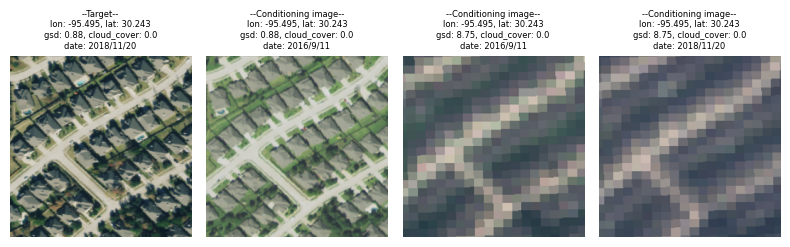

In [15]:
pretty_plot(caption, metadata, cond_metadata, target_img, cond_imgs_pil)

#### Prompt Pipe: Controlnet + finetuned StableDiffusion with metadata + 3 cond images

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.63it/s]


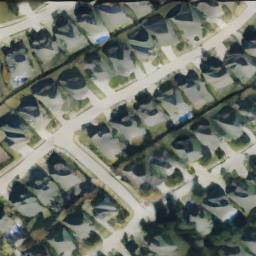

In [18]:
# You can play around with these parameters to change the quality of the generation
image = pipe(caption.replace('naip', 'satlas'), [cond_imgs_pil], 
              metadata=metadata, cond_metadata=cond_metadata, 
              num_inference_steps=50, guidance_scale=1.0, is_temporal=True).images[0]
image